#Домашняя работа №5

*Реализовать минимум 5 регрессоров, сравнить метрики между собой, выбрать лучший для Вашего датасета.*

In [6]:
!pip install kaggle

In [8]:
!mkdir -p ~/.kaggle

In [9]:
# Загрузите свой kaggle.json (нужен аккаунт Kaggle)
from google.colab import files
files.upload()  # Загрузите kaggle.json

!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Скачиваем датасет
!kaggle datasets download -d mczielinski/bitcoin-historical-data

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data
License(s): CC-BY-SA-4.0
  0% 0.00/97.2M [00:00<?, ?B/s]
100% 97.2M/97.2M [00:00<00:00, 1.04GB/s]


--- Шаг 1: Загрузка, очистка и инженерия признаков ---
Ошибка загрузки с Kaggle: name 'KaggleApi' is not defined
Использование локально доступного файла: btcusd_1-min_data.csv
Использована подвыборка из последних 100000 записей.

--- Информация о данных ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7244316 entries, 2012-01-01 10:01:00 to 2025-10-10 23:56:00
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Open    float64
 1   High    float64
 2   Low     float64
 3   Close   float64
 4   Volume  float64
dtypes: float64(5)
memory usage: 331.6 MB

--- Статистика данных ---
               Open          High           Low         Close        Volume
count  7.244316e+06  7.244316e+06  7.244316e+06  7.244316e+06  7.244316e+06
mean   2.042666e+04  2.043403e+04  2.041908e+04  2.042666e+04  5.161981e+00
std    2.891261e+04  2.892039e+04  2.890470e+04  2.891261e+04  2.217254e+01
min    3.800000e+00  3.800000e+00  3.800000e+00  3.800000e+00  0.000000e+00
2

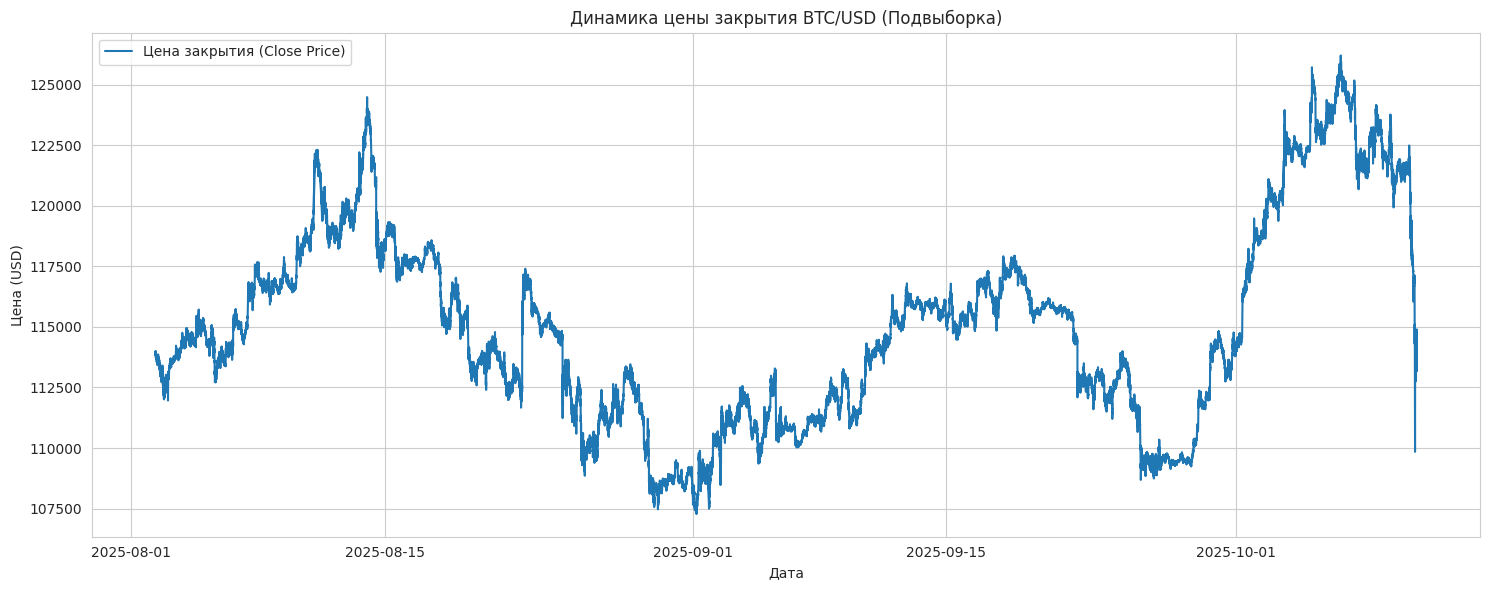

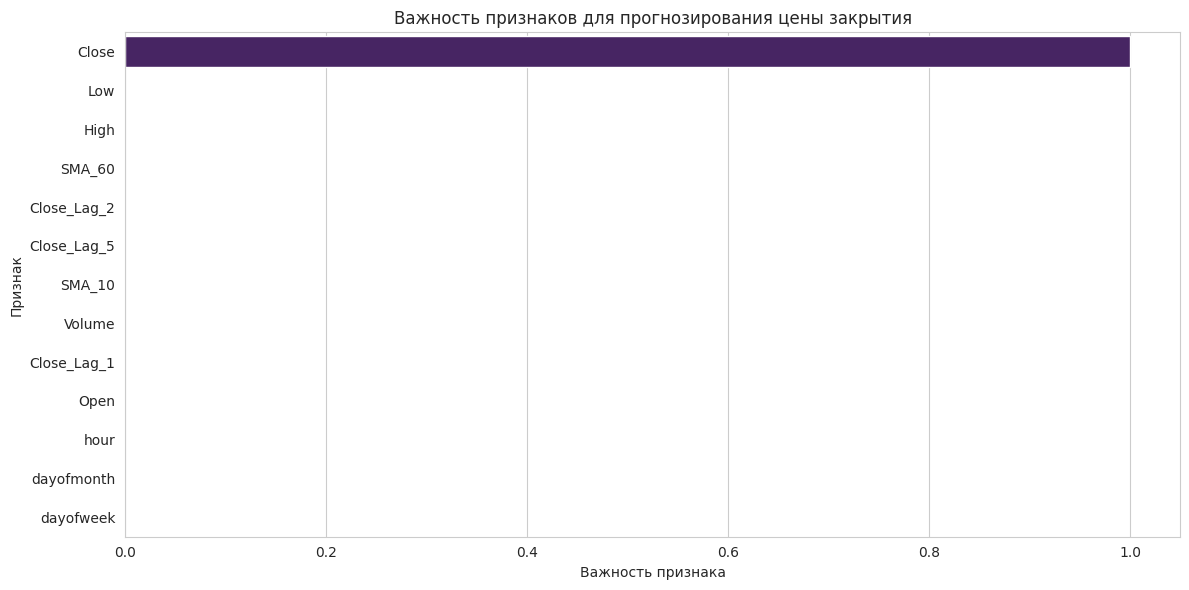


--- Шаг 3: Обучение моделей и оценка метрик ---
Модель: LinearRegression           R2=0.999873, MAE=34.2774, Time=0.07s
Модель: Lasso                      R2=0.999852, MAE=36.6492, Time=54.09s
Модель: Ridge                      R2=0.999872, MAE=34.5156, Time=0.06s
Модель: ElasticNet                 R2=0.999828, MAE=39.5940, Time=53.43s
Модель: BayesianRidge              R2=0.999873, MAE=34.2767, Time=0.10s
Модель: HuberRegressor             R2=0.999874, MAE=34.2153, Time=19.18s
Модель: OrthogonalMatchingPursuit  R2=0.999874, MAE=34.2438, Time=0.07s
Модель: PassiveAggressiveRegressor R2=0.999794, MAE=52.7563, Time=0.97s
Модель: DecisionTreeRegressor      R2=0.997713, MAE=104.7178, Time=1.44s
Модель: KNeighborsRegressor        R2=0.997949, MAE=101.1789, Time=0.75s
Модель: RandomForestRegressor      R2=0.998074, MAE=88.5938, Time=58.06s
Модель: ExtraTreesRegressor        R2=0.997429, MAE=103.2444, Time=5.29s
Модель: GradientBoostingRegressor  R2=0.997712, MAE=98.3469, Time=66.93s
Модель:

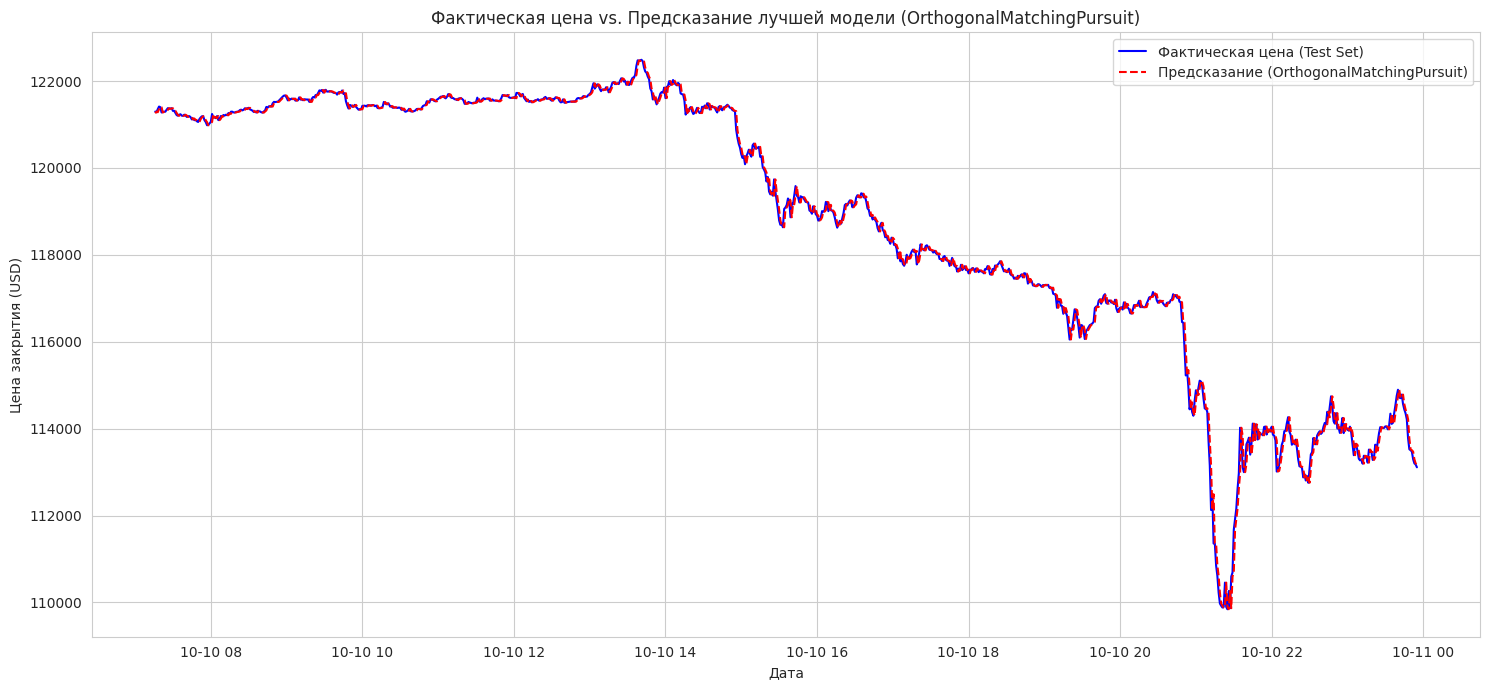

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    ExtraTreesRegressor,
    AdaBoostRegressor,
    VotingRegressor,
)
from sklearn.linear_model import (
    Lasso,
    Ridge,
    BayesianRidge,
    LinearRegression,
    HuberRegressor,
    OrthogonalMatchingPursuit,
    PassiveAggressiveRegressor,
    ElasticNet,
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import time
import os
import zipfile


# Установка стиля для графиков
sns.set_style("whitegrid")

# Игнорирование предупреждений для чистоты вывода
warnings.filterwarnings('ignore')

def load_and_preprocess_data(file_name):
    """
    Загружает данные, выполняет предобработку, очистку и инженерию признаков.
    """
    print("--- Шаг 1: Загрузка, очистка и инженерия признаков ---")
    # df = pd.read_csv(file_name)

    # Константы для Kaggle
    dataset_name = "mczielinski/bitcoin-historical-data"

    # Файл, который находится внутри скачанного ZIP-архива
    kaggle_file_name = "bitstampUSD_1-min_data_2012-01-01_to_2020-09-13.csv"

    # Попытка загрузки с Kaggle
    try:
        # Аутентификация Kaggle API (предполагается, что kaggle.json настроен в Colab)
        api = KaggleApi()
        api.authenticate()

        print(f"Скачивание датасета {dataset_name}...")
        # Скачиваем и распаковываем
        api.dataset_download_files(dataset_name, path="./", unzip=True)

        df = pd.read_csv(kaggle_file_name)
        print(f"Успешная загрузка файла: {kaggle_file_name}")

    except Exception as e:
        print(f"Ошибка загрузки с Kaggle: {e}")
        print(f"Использование локально доступного файла: {file_name}")
        # Резервный вариант: использование локального файла
        df = pd.read_csv(file_name)

    df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit="s")
    df.set_index("Timestamp", inplace=True)

    # 1. Очистка: удаление строк с нулевым объемом
    df_cleaned = df[df["Volume"] > 0].copy()

    # 2. Инженерия признаков
    df_cleaned["Target_Close"] = df_cleaned["Close"].shift(-1)
    df_cleaned["Close_Lag_1"] = df_cleaned["Close"].shift(1)
    df_cleaned["Close_Lag_2"] = df_cleaned["Close"].shift(2)
    df_cleaned["Close_Lag_5"] = df_cleaned["Close"].shift(5)
    df_cleaned["SMA_10"] = df_cleaned["Close"].rolling(window=10).mean()
    df_cleaned["SMA_60"] = df_cleaned["Close"].rolling(window=60).mean()
    df_cleaned["hour"] = df_cleaned.index.hour
    df_cleaned["dayofweek"] = df_cleaned.index.dayofweek
    df_cleaned["dayofmonth"] = df_cleaned.index.day

    df_model = df_cleaned.dropna()

    # Используем только последние N строк для ускорения вычислений
    n_subset = 100000
    df_subset = df_model.iloc[-n_subset:].copy()
    print(f"Использована подвыборка из последних {n_subset} записей.")

    # 3. Информация о данных и статистика
    print("\n--- Информация о данных ---")
    df.info()
    print("\n--- Статистика данных ---")
    print(df.describe())
    print("\n--- Первые 5 строк ---")
    print(df.head())

    return df_subset

def visualize_data(df):
    """
    Визуализирует цену закрытия и важность признаков.
    """
    print("\n--- Шаг 2: Визуализация и оценка важности признаков ---")
    # Визуализация цены
    plt.figure(figsize=(15, 6))
    plt.plot(df["Close"], label="Цена закрытия (Close Price)")
    plt.title("Динамика цены закрытия BTC/USD (Подвыборка)")
    plt.xlabel("Дата")
    plt.ylabel("Цена (USD)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Оценка важности признаков
    X = df.drop(columns=["Target_Close"])
    y = df["Target_Close"]

    rf_feature_importance = RandomForestRegressor(
        n_estimators=100, random_state=42, n_jobs=-1
    )
    rf_feature_importance.fit(X, y)

    feature_importances = pd.Series(
        rf_feature_importance.feature_importances_, index=X.columns
    ).sort_values(ascending=False)

    # Визуализация важности признаков
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=feature_importances.values, y=feature_importances.index, palette="viridis"
    )
    plt.title("Важность признаков для прогнозирования цены закрытия")
    plt.xlabel("Важность признака")
    plt.ylabel("Признак")
    plt.tight_layout()
    plt.show()


def define_regressors(ensemble_base_models):
    """
    Определяет словарь регрессоров с параметрами.
    """
    # Подбор параметров для сильных моделей выполнен вручную/на основе предыдущего шага
    # Для линейных моделей используется Pipeline со StandardScaler
    regressors = {
        # Регрессоры, требующие масштабирования
        "LinearRegression": LinearRegression(),
        "Lasso": Lasso(alpha=0.001, max_iter=20000),
        "Ridge": Ridge(alpha=1.0, max_iter=20000),
        "ElasticNet": ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=20000),
        "BayesianRidge": BayesianRidge(),
        "HuberRegressor": HuberRegressor(epsilon=1.35, max_iter=1000),
        "OrthogonalMatchingPursuit": OrthogonalMatchingPursuit(),
        "PassiveAggressiveRegressor": PassiveAggressiveRegressor(
            max_iter=1000, random_state=42, tol=1e-3
        ),
        # Древовидные и бустинговые (с подобранными параметрами)
        "DecisionTreeRegressor": DecisionTreeRegressor(max_depth=10, random_state=42),
        "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=5, n_jobs=-1),
        "RandomForestRegressor": RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            min_samples_split=5,
            random_state=42,
            n_jobs=-1,
        ),
        "ExtraTreesRegressor": ExtraTreesRegressor(
            n_estimators=100, max_depth=10, random_state=42, n_jobs=-1
        ),
        "GradientBoostingRegressor": GradientBoostingRegressor(
            n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42
        ),
        "AdaBoostRegressor": AdaBoostRegressor(
            n_estimators=100, learning_rate=0.1, random_state=42
        ),
        # Фиктивный регрессор
        "DummyRegressor": DummyRegressor(strategy="mean"),
    }

    models = {}
    for name, regressor in regressors.items():
        if name in [
            "LinearRegression",
            "Lasso",
            "Ridge",
            "ElasticNet",
            "BayesianRidge",
            "HuberRegressor",
            "OrthogonalMatchingPursuit",
            "PassiveAggressiveRegressor",
        ]:
            models[name] = Pipeline([("scaler", StandardScaler()), ("regressor", regressor)])
        else:
            models[name] = regressor

    # Ансамбль регрессоров
    models["VotingRegressor"] = VotingRegressor(
        estimators=ensemble_base_models, n_jobs=-1
    )

    return models


def train_and_evaluate_models(df_subset):
    """
    Обучает и оценивает все модели.
    """
    print("\n--- Шаг 3: Обучение моделей и оценка метрик ---")
    X = df_subset.drop(columns=["Target_Close"])
    y = df_subset["Target_Close"]

    # Разделение набора данных: 80% обучение, 20% тест (временной сплит)
    split_index = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

    # Базовые модели для ансамбля
    ensemble_base_models = [
        (
            "RF",
            RandomForestRegressor(
                n_estimators=100, max_depth=10, random_state=42, n_jobs=-1
            ),
        ),
        (
            "GB",
            GradientBoostingRegressor(
                n_estimators=100, max_depth=5, random_state=42
            ),
        ),
        (
            "ET",
            ExtraTreesRegressor(
                n_estimators=100, max_depth=10, random_state=42, n_jobs=-1
            ),
        ),
    ]

    models = define_regressors(ensemble_base_models)
    results = []
    best_r2 = -np.inf
    best_model_name = ""
    best_y_pred = None

    for name, model in models.items():
        start_time = time.time()
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            r2 = r2_score(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            fit_time = time.time() - start_time

            results.append(
                {
                    "Модель": name,
                    "R2": r2,
                    "MAE": mae,
                    "RMSE": rmse,
                    "Время обучения (с)": fit_time,
                }
            )

            if r2 > best_r2:
                best_r2 = r2
                best_model_name = name
                best_y_pred = y_pred

            print(f"Модель: {name:<26} R2={r2:.6f}, MAE={mae:.4f}, Time={fit_time:.2f}s")

        except Exception as e:
            print(f"Модель: {name:<26} ОШИБКА: {e}")
            results.append(
                {
                    "Модель": name,
                    "R2": np.nan,
                    "MAE": np.nan,
                    "RMSE": np.nan,
                    "Время обучения (с)": time.time() - start_time,
                }
            )

    results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False)
    print("\n--- Сводка по метрикам моделей (по убыванию R2) ---")
    print(results_df.to_string(index=False))

    return results_df, best_model_name, y_test, best_y_pred


def plot_best_prediction(best_model_name, y_test, best_y_pred):
    """
    Создает график факта и предсказания для лучшей модели.
    """
    print("\n--- Шаг 4: Визуализация лучшего прогноза ---")
    # Визуализируем фактические и прогнозные цены на части тестового набора.
    plot_points = 1000
    y_test_plot = y_test.iloc[-plot_points:]
    y_pred_plot = pd.Series(best_y_pred[-plot_points:], index=y_test_plot.index)

    plt.figure(figsize=(15, 7))
    plt.plot(y_test_plot, label="Фактическая цена (Test Set)", color="blue")
    plt.plot(
        y_pred_plot,
        label=f"Предсказание ({best_model_name})",
        color="red",
        linestyle="--",
    )
    plt.title(f"Фактическая цена vs. Предсказание лучшей модели ({best_model_name})")
    plt.xlabel("Дата")
    plt.ylabel("Цена закрытия (USD)")
    plt.legend()
    plt.tight_layout()
    print(f"График прогноза для лучшей модели ({best_model_name}):")
    plt.show()

def main():
    """
    Основной алгоритм для прогнозирования цены Bitcoin.
    """
    file_name = "btcusd_1-min_data.csv"

    # Шаг 1: Загрузка, предобработка и инженерия признаков
    df_subset = load_and_preprocess_data(file_name)

    # Шаг 2: Визуализация и оценка важности признаков
    visualize_data(df_subset)

    # Шаг 3: Обучение и оценка моделей
    results_df, best_model_name, y_test, best_y_pred = train_and_evaluate_models(
        df_subset
    )

    # Выбор лучшего регрессора и вывод
    best_model_row = results_df.iloc[0]
    print("\n=======================================================")
    print("ВЫВОД: ЛУЧШИЙ РЕГРЕССОР ДЛЯ ПРОГНОЗА ЦЕНЫ")
    print("=======================================================")
    print(f"Модель: {best_model_row['Модель']}")
    print(f"R2 (коэффициент детерминации): {best_model_row['R2']:.6f}")
    print(f"MAE (средняя абсолютная ошибка): {best_model_row['MAE']:.6f}")
    print(f"RMSE (корень из среднеквадратичной ошибки): {best_model_row['RMSE']:.6f}")
    print("=======================================================")

    # Шаг 4: Визуализация лучшего прогноза
    plot_best_prediction(best_model_name, y_test, best_y_pred)


if __name__ == "__main__":
    main()
